In [1]:
import numpy as np
import pandas as pd
import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [3]:
# Loading preprocessed data
data = pd.read_csv('Titanic_cleaned_data.csv',index_col=0)

data_val = pd.read_csv('Titanic_cleaned_data_validation.csv',index_col=0)

In [4]:
data.head()

,Survived,Pclass,Sex,Age_band,SibSp,Parch,Family_Size,Alone,Fare_cat,Embarked,Initial
0,0,3,male,1,1,0,2,0,0,S,Mr
1,1,1,female,2,1,0,2,0,3,C,Mrs
2,1,3,female,1,0,0,1,1,1,S,Miss
3,1,1,female,2,1,0,2,0,3,S,Mrs
4,0,3,male,2,0,0,1,1,1,S,Mr


### Appling Feature Engineering

In [5]:
LABEL_FEATURES = ['Sex','Embarked','Initial']

label_enc = LabelEncoder()
for column in LABEL_FEATURES:
    # Modeling + Transforming
    data[column] = label_enc.fit_transform(data[column])
    # Transforming
    data_val[column] = label_enc.transform(data_val[column])

In [6]:
data.head()

,Survived,Pclass,Sex,Age_band,SibSp,Parch,Family_Size,Alone,Fare_cat,Embarked,Initial
0,0,3,1,1,1,0,2,0,0,2,2
1,1,1,0,2,1,0,2,0,3,0,3
2,1,3,0,1,0,0,1,1,1,2,1
3,1,1,0,2,1,0,2,0,3,2,3
4,0,3,1,2,0,0,1,1,1,2,2


In [7]:
### Lets check null again
data.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age_band       0
SibSp          0
Parch          0
Family_Size    0
Alone          0
Fare_cat       0
Embarked       0
Initial        0
dtype: int64

In [8]:
data_val.isnull().sum()

Survived       0
Pclass         0
Sex            0
Age_band       0
SibSp          0
Parch          0
Family_Size    0
Alone          0
Fare_cat       0
Embarked       0
Initial        0
dtype: int64

### Co-relation plot

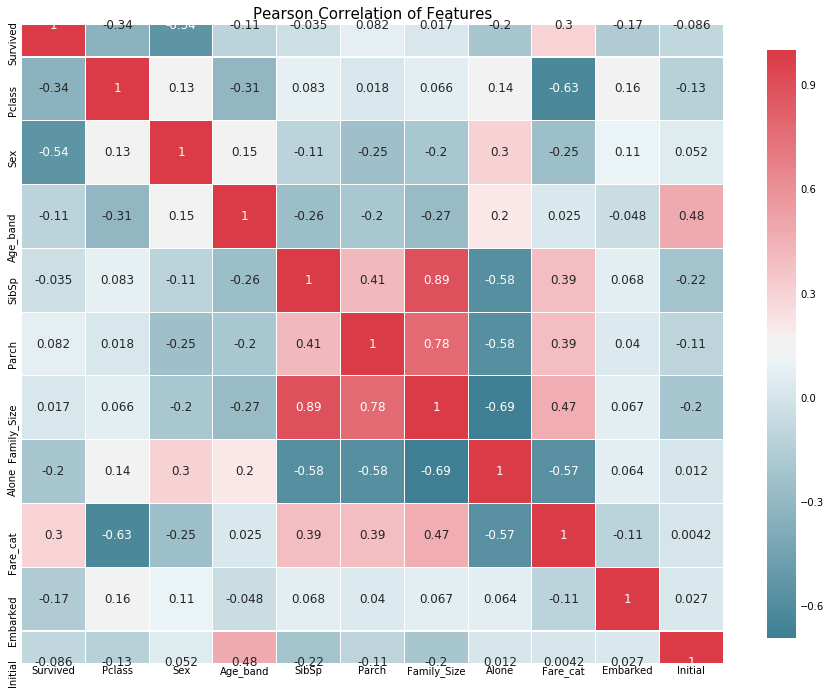

In [9]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)

### Feature and Target

In [10]:
X = data.drop(['Survived'],axis=1)
y = data['Survived']

X.shape, y.shape

((891, 10), (891,))

### Feature Selection/ Elimination

In [11]:
from sklearn.feature_selection import VarianceThreshold

In [12]:
# Constant and Quasi feature removal
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(X)
print(quasi_constant_filter.get_support().sum())


selectedColumnIndexes = [i for i, val in enumerate(quasi_constant_filter.get_support()) if val]
selecedColumns = X.columns[selectedColumnIndexes]


X_train_quasi_filter = pd.DataFrame(quasi_constant_filter.transform(X),columns=selecedColumns)

print(X.shape,X_train_quasi_filter.shape)

10
(891, 10) (891, 10)


In [13]:
corrmat = X_train_quasi_filter.corr()

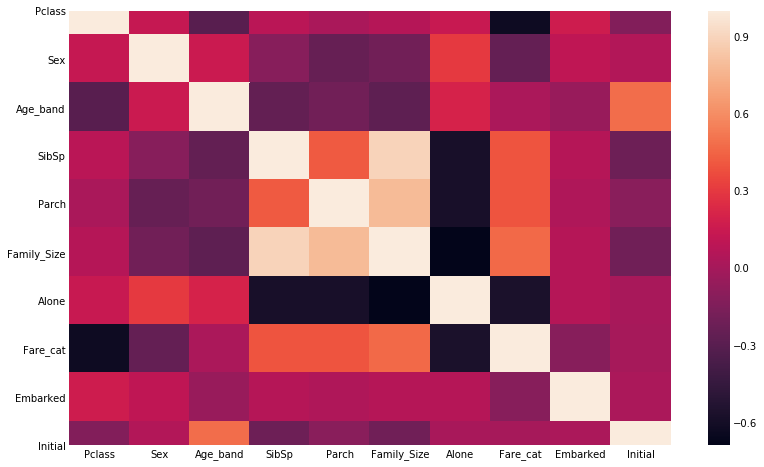

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

In [15]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j]) > threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col

corr_features = get_correlation(X_train_quasi_filter,0.85)

In [16]:
corr_features

{'Family_Size'}

In [17]:
X_train_uncorr = X_train_quasi_filter.drop(labels=corr_features,axis=1)

print(X.shape,X_train_quasi_filter.shape,X_train_uncorr.shape)

(891, 10) (891, 10) (891, 9)


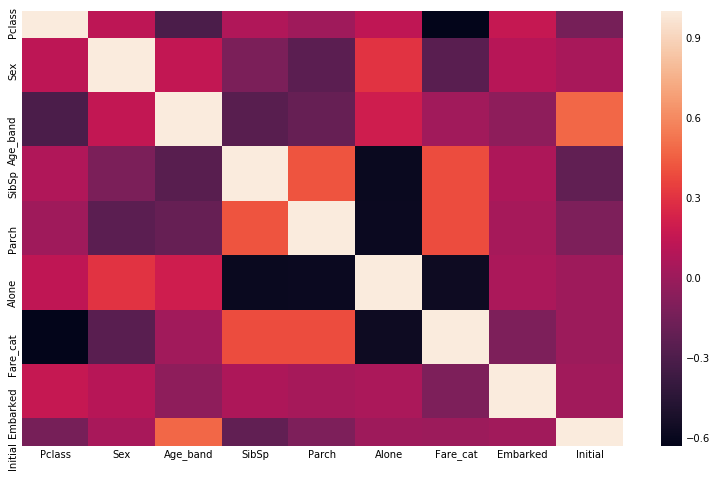

In [18]:
corrmat = X_train_uncorr.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corrmat)

### Doing Train-Test Split

* We will now split out Training data into two halfs where one will be used for trainig and other will be used for validating model
* Note that we have not taken action yet on test dataset

In [19]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X_train_uncorr,y,test_size=0.2,random_state=0,stratify=y)

In [21]:
X_train.shape, X_test.shape

((712, 9), (179, 9))

In [22]:
def executeModels(clfs,X_train,X_test,y_train,y_test):
    for name, clf in clfs:
        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, prediction))
        print(confusion_matrix(y_test, prediction))
        print('Accuracy is ', accuracy_score(y_test, prediction)*100)
        print('='*100)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [24]:
# Models
classifiers = [
    # Logistic Classifier
    ('Logistic',LogisticRegression()),

    #Gaussian Processes
    ('Gausian',GaussianProcessClassifier()),
    
    #Navies Bayes
    ('Naive Bayes',GaussianNB()),
    
    #Nearest Neighbor
    ('KNN',KNeighborsClassifier()),
    
    #SVM
    ('SVC',SVC(probability=True)),
    
    #Trees    
    ('Decision Tree',DecisionTreeClassifier()),
   
    #Ensemble Classifier
    ('Random Forest',RandomForestClassifier()),
        
]

### Applying ML

In [25]:
executeModels(classifiers,X_train,X_test,y_train,y_test)

Logistic
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.72      0.64      0.68        69

    accuracy                           0.77       179
   macro avg       0.75      0.74      0.75       179
weighted avg       0.76      0.77      0.76       179

[[93 17]
 [25 44]]
Accuracy is  76.53631284916202
Gausian
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       110
           1       0.82      0.68      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179

[[100  10]
 [ 22  47]]
Accuracy is  82.12290502793296
Naive Bayes
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       110
           1       0.68      0.75      0.71        69

    accuracy                           0.77      

### Lets apply Cross Validation to get Assured about results

In [26]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

In [27]:
cv_split = ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )

result_columns = ['Alg-Name', 'Alg-Parameters', 'Alg-CV test accuracy', 'Alg-Actual test accuracy', 'Alg Time']
result_compare = pd.DataFrame(columns = result_columns)

row_index=0
for name, alg in classifiers:
    clf_name = alg.__class__.__name__
    result_compare.loc[row_index, 'Alg-Name'] = clf_name
    result_compare.loc[row_index, 'Alg-Parameters'] = str(alg.get_params())
    
    # Cross validation
    cv_results = cross_validate(alg, X_train, y_train, cv  = cv_split)
  
    result_compare.loc[row_index, 'Alg Time'] = cv_results['fit_time'].mean()
    result_compare.loc[row_index, 'Alg-CV test accuracy'] = cv_results['test_score'].mean()
  
    alg.fit(X_train, y_train)
    prediction = alg.predict(X_test)
    accuracy_scr = accuracy_score(y_test, prediction)*100
    result_compare.loc[row_index, 'Alg-Actual test accuracy'] = accuracy_scr
    
    row_index+=1

In [28]:
result_compare.sort_values(by = ['Alg-Actual test accuracy'], ascending = False, inplace = True)
result_compare

,Alg-Name,Alg-Parameters,Alg-CV test accuracy,Alg-Actual test accuracy,Alg Time
1,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.811682,82.1229,0.229174
4,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837383,81.5642,0.0356162
3,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.798598,81.0056,0.00327547
6,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.81729,79.3296,0.0134991
5,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.795327,77.095,0.00194376
0,LogisticRegression,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.803271,76.5363,0.00408311
2,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.797664,76.5363,0.0064255


### We are getting GaussianProcessClassifier as best model

* Applying on test dataset

In [29]:
X_train

,Pclass,Sex,Age_band,SibSp,Parch,Alone,Fare_cat,Embarked,Initial
502,3,0,1,0,0,1,0,1,1
464,3,1,2,0,0,1,1,2,2
198,3,0,1,0,0,1,0,1,1
765,1,0,3,1,0,0,3,2,3
421,3,1,1,0,0,1,0,1,2
...,...,...,...,...,...,...,...,...,...
131,3,1,1,0,0,1,0,2,2
490,3,1,2,1,0,0,2,2,2
528,3,1,2,0,0,1,1,2,2
48,3,1,2,2,0,0,2,0,2


In [30]:
data_cleaned = data_val[X_train.columns]

In [31]:
data_cleaned.head()

,Pclass,Sex,Age_band,SibSp,Parch,Alone,Fare_cat,Embarked,Initial
0,3,1,1,1,0,0,0,2,2
1,1,0,2,1,0,0,3,0,3
2,3,0,1,0,0,1,1,2,1
3,1,0,2,1,0,0,3,2,3
4,3,1,2,0,0,1,1,2,2


In [32]:
model = GaussianProcessClassifier()
model.fit(X_train, y_train)

GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=100,
                          multi_class='one_vs_rest', n_jobs=None,
                          n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
                          random_state=None, warm_start=False)

In [33]:
final_result = model.predict(data_cleaned)

In [34]:
final_result

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,

## Thanks...Happy Learning